# Neural Networks Basics

This notebook contains a bare-bones pipeline for training and evaluating a neural network using Pytorch.

Though the network is simple and the data is generated randomly, this template contains elements that would be useful in many more complex settings. 

## Set up

0. Optional but strongly recommended: install a package/environment manager like [Conda](https://docs.conda.io/projects/conda/en/latest/). I recommend [Miniconda](https://docs.conda.io/en/latest/miniconda.html) for a minimal option.
   - Create a new environment and activate it before installing the remaining packages
1. If using this code in a Jupyter notebook, install [Jupyter](https://jupyter.org/install) and run `jupyter notebook` from your terminal to launch a server you can use from your browser
2. Install the current Pytorch version appropriate for your system:
https://pytorch.org/get-started/locally/

### Other useful packages used in this code
- numpy 
- tqdm
- matplotlib

In [1]:
# Code setup
import torch
import random
import numpy as np
import tqdm
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# set seed for reproducibility
torch.manual_seed(0)  
random.seed(0)
np.random.seed(0)

## Data setup

In [2]:
def split_data(X, y, splits, random=True):
    """split data into C partitions, equal to the length of argument splits
    
    X: a data matrix Nxd with N examples with d features
    y: an Nxt matrix with targets for the examples in X. The indices should match X
    splits: an iterable (eg list) of C proportions to split indices into C partitions
    random (bool): sample indices randomly if True (default) or in order if False
    """
    
    # scale splits to sum to 1 in case they dont
    splits = np.array(splits)
    splits = splits/sum(splits) 
    
    # Get integer number of samples in each partition based on splits
    num_samples = X.shape[0]
    assert y.shape[0]==num_samples, "First dimension of data matrix X and targets y should be equal"
    num_splits = np.floor(num_samples * splits)
    num_splits[-1] = num_samples - np.sum(num_splits[:-1])
    num_splits = np.cumsum(num_splits).astype(np.int)
    
    # Get samples in each partition
    if random:
        idxs = np.random.permutation(num_samples)
        X = X[idxs]
        y = y[idxs]
    X = np.split(X, num_splits[:-1])
    y = np.split(y, num_splits[:-1])
    
    return zip(X, y)
    

In [3]:
# 1. Load data (replace with dataset of your choice)
dim = 200
num_classes = 2
X = np.random.rand(1000, dim).astype(np.float32)
y = np.random.choice(num_classes, 1000).reshape([-1, 1]).astype(np.float32)

# 2. Split into train, validation, test
(train_X, train_y), (val_X, val_y), (test_X, test_y) = split_data(X, y, [0.6, 0.2, 0.2])

# 3. Create Pytorch datasets and dataloaders 
batch_size = 16

train_dataset = TensorDataset(torch.tensor(train_X), torch.tensor(train_y))
val_dataset = TensorDataset(torch.tensor(val_X), torch.tensor(val_y))
test_dataset = TensorDataset(torch.tensor(test_X), torch.tensor(test_y))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Create Model Architecture

In [4]:
class myNN(nn.Module):
    """
    This neural network has linear (fully connected) layers, each followed ReLU activation functions.
    The final output is passed through as sigmoid function for binary classification
    """
    def __init__(self, input_size, num_layers=3, hidden_size=512, output_size=1):
        super(myNN, self).__init__()
        
        self.layers = nn.ModuleList([nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU())])
        
        for _ in range(num_layers - 2):
            self.layers.append(nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.ReLU()))
        self.layers.append(nn.Sequential(nn.Linear(hidden_size, output_size)))
        self.sig = nn.Sigmoid()
        
    @property
    def device(self):
        return next(model.parameters()).device
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        
        return self.sig(x)

## Initialize and Train Model

In [5]:
# Training a Network 
def train_epoch(dataloader, model, loss_fxn, optimizer):
    
    epoch_loss = 0
    optimizer.zero_grad()
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(model.device), y_batch.to(model.device)
        prediction = model(x_batch)
        epoch_loss += loss_fxn(prediction, y_batch)

        
    # Backpropagation
    epoch_loss.backward()
    optimizer.step()
    
    return epoch_loss

# Evaluate model
def eval_epoch(dataloader, model, loss_fxn):
    # loss_fxn can instead be an evaluation function, eg classification errors, to return error instead of loss
    epoch_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(model.device), y_batch.to(model.device)
            prediction = model(x_batch)
            epoch_loss += loss_fxn(prediction, y_batch)
    return epoch_loss

In [6]:
# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

model = myNN(input_size=dim)
model.to(device)

# Loss function, optimizer, and training options
learning_rate = 1e-4
num_epochs = 500
loss_fxn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
pbar = tqdm.trange(1, num_epochs + 1, unit="epoch")

train_losses = np.zeros([num_epochs])
val_losses = np.zeros([num_epochs])
for epoch,_ in enumerate(pbar):
    train_loss = train_epoch(train_loader, model, loss_fxn, optimizer)
    val_loss = eval_epoch(val_loader, model, loss_fxn)
    
    train_loss = train_loss.item()/len(train_loader.dataset)
    val_loss = val_loss.item()/len(val_loader.dataset)
    
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    pbar.set_postfix({'Train loss': train_loss, 'Validation loss': val_loss})

100%|██████████| 500/500 [00:30<00:00, 16.14epoch/s, Train loss=0.000293, Validation loss=0.114] 


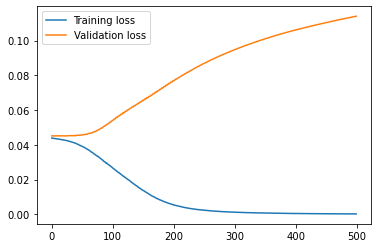

In [8]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()

## Hyperparameter tuning

Before evaluating trained model on the test data, experiment with hyperparameters, including any of the following:
- learning rate, learning rate decay schedule
- batch size 
- number of epochs
- number of layers
- layer hidden dimension
- optimizer
- loss function
- other architecture choices
- regularization options (not included here, hence the poor performance on validation data)

The best model will be the one that performs best on the validation data. "Best" is *usually* determined by the error function, not the loss function, but it depends on the learning task

## Final Evaluation
Once the model is "frozen," can evaluate on the test data set. Again, usually we want to replace the loss function with some error function instead (eg classification error)

In [9]:
test_loss = eval_epoch(test_loader, model, loss_fxn)
print('Avg loss per test sample: {0:.4f}'.format(test_loss.item()/len(test_loader.dataset)))

Avg loss per test sample: 0.1031
